# Prédiction du nombre de nouveaux étudiants en L1

## 1. Prétraitement des données

- Importation des librairies
- Importation du jeu de données
- Nettoyage des données:
    1. Verification s'il y a des données manquantes au jeu de données

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Récupéraion du dataset

In [2]:
df = pd.read_csv("datas/prop_admi_post_bac.csv",sep=";")

Visualisation des données

In [3]:
df.head(5)

,Année du Baccalauréat,Enseignements de spécialité,Formation,Nombre de candidats bacheliers ayant confirmé au moins un vœu,Nombre de candidats bacheliers ayant reçu au moins une proposition d'admission,Nombre de candidats bacheliers ayant accepté une proposition d'admission
0,2021,"Art,Art","Licence Electronique, Génie électrique, EEA",0,0.0,0
1,2021,"Art,Art",Licence Formation générale aux métiers de l in...,0,0.0,0
2,2021,"Art,Art",Licence LEA,0,0.0,0
3,2021,"Art,Art",Licence Mathématiques,0,0.0,0
4,2021,"Art,Art",Licence Mathématiques et informatique,0,0.0,0


Nous vérifions si une colonne comporte des données manquantes. Comme nous pouvons le voir, aucune ligne n'est vide.

In [4]:
df.isna().sum()

Année du Baccalauréat                                                             0
Enseignements de spécialité                                                       0
Formation                                                                         0
Nombre de candidats bacheliers ayant confirmé au moins un vœu                     0
Nombre de candidats bacheliers ayant reçu au moins une proposition d'admission    0
Nombre de candidats bacheliers ayant accepté une proposition d'admission          0
dtype: int64

Renommage des colonnes par soucis de simplification lors du traitement.

In [5]:
df.rename(columns={"Année du Baccalauréat" : "annee",
           "Enseignements de spécialité" : "spe",
           "Formation": "formation",
           "Nombre de candidats bacheliers ayant confirmé au moins un vœu" : "voeu_confirme",
           "Nombre de candidats bacheliers ayant reçu au moins une proposition d'admission" : "prop_recu",
           "Nombre de candidats bacheliers ayant accepté une proposition d'admission" : "prop_accepte"}, inplace=True)
df.head(5)

,annee,spe,formation,voeu_confirme,prop_recu,prop_accepte
0,2021,"Art,Art","Licence Electronique, Génie électrique, EEA",0,0.0,0
1,2021,"Art,Art",Licence Formation générale aux métiers de l in...,0,0.0,0
2,2021,"Art,Art",Licence LEA,0,0.0,0
3,2021,"Art,Art",Licence Mathématiques,0,0.0,0
4,2021,"Art,Art",Licence Mathématiques et informatique,0,0.0,0


Vérification et correction au besoin des types de données.

Ici on remarque que prop_recu est de type float64. Aucune des valeurs de la colonne n'est de type float, on peu donc passer la colonne en Int.

In [6]:
df.dtypes

annee              int64
spe               object
formation         object
voeu_confirme      int64
prop_recu        float64
prop_accepte       int64
dtype: object

In [7]:
df["prop_recu"].value_counts().unique()

array([4022, 1091,  641,  412,  325,  257,  228,  216,  169,  141,  132,
        117,  115,   91,   87,   82,   78,   75,   74,   71,   65,   60,
         59,   52,   48,   46,   43,   42,   40,   39,   37,   36,   35,
         34,   29,   27,   25,   23,   22,   21,   20,   19,   18,   17,
         16,   15,   14,   13,   12,   11,   10,    9,    8,    7,    6,
          5,    4,    3,    2,    1])

In [8]:
df["prop_recu"] = df["prop_recu"].astype(int)

In [9]:
df.dtypes

annee             int64
spe              object
formation        object
voeu_confirme     int64
prop_recu         int64
prop_accepte      int64
dtype: object

On sait que le nouveau bac demande à choisir une spécialité dominante et une spécialité secondaire. On remarque que la colonne spe sépare ses données par une virgule, mais parfois le nom d'une spécialité contient une virgule. On remarque également que lorsque la virgule sépare deux spécialités (Art,Art), il n'y a pas d'espace après celle-ci, et que quand la virgule est dans le nom d'une spécialité, (Histoire-Géographie, Géopolitique et Sciences politiques), il y a un espace après la virgule. 

Pour pouvoir continuer à traiter les données nous décidons de séparer la colonne `spe` en deux colonnes distinctes, l'une contenant la spécialité principale `spe_prim` et l'autre la spécialité secondaire `spe_sec`.
Le but est ainsi de pouvoir aisement trier selon l'une ou l'autre des spécialités ainsi que de pouvoir comparer les duos de spécialité menant à une certaine formation dans l'enseignement supérieur.

In [10]:
import re

def split_string(text):
    result = re.split(r'(?<=\w),(?=\w)', text)
    return pd.Series([result[0],result[1]])

df[['spe_prim', 'spe_sec']] = df['spe'].apply(split_string)

## Lecture des données

Nous avons 6 variables différentes dans notre dataset :

- annee :
    - L'année du passage du BAC pour les étudiants
    - type *int*, [2021-2023]
- spé :
    - Spécialités lors du passage du BAC
    - type *(string, string)*: (spé1,spé2)
- formation : 
    - Formation postulés par les étudiants, 
    - type *string*
- voeu_accepté :
    - Nombre de voeux confirmés par les étudiants
    - type *int*, [0, inf]
- prop_recu :
    - Nombre de propositions d'admission reçus par les étudiants
    - type *int*, [0, prop_reçu]
- prop_accepte :
     - Nombre de proposition d'admission acceptés par les étudiants
    - type *int*, [0, voeu_accepté]

## Première visualisation

Pour commencer, nous allons regarder globalement ce que nous disent ces données. Pour se faire nous allons faire deux visualisations. 

- La première consiste à regarder pour chaque duo de spécialités :
    - Quelle formation ce duo demande le plus.
    - De quelle formation ce duo reçois le plus de propositions d'admissions.
    - Dans quelle formation ce duo accepte finnalement une proposition d'admission.
- La seconde sera la même chose mais du point de vue de chaque formation:
    - Quel duo de spécialité demande le plus cette formation.
    - A quel duo cette formation envoie le plus d'offre d'admissions.
    - De quel duo de spécialité cette formation reçois finalement le plus d'étudiants.

Cette première visualisation nous permettra de mettre en évidence une première tendance entre les formations et les duos.

Dans les données pour chaque années et chaque duo de formation se trouve une ligne "Ensemble des bacheliers" qui regroupe pour cette année et ce duo le total des demandes et confirmations. Pour que la visualisation ne nous donne pas à chaque fois ce total, on utilise un mask pour enlever la ligne en question, mais sans l'enlever de notre dataframe car on pourrait en avoir besoin plus tard.

In [11]:
df = df[df['formation'] != 'Ensemble des bacheliers']

In [12]:
max_clean = df["voeu_confirme"].max()
print(max_clean)

59892


In [13]:
def create_graph_from_spe(df,colonne, annee) :
    df_graph = df.head(10)
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df_graph, x=colonne, y='spe', hue='formation')
    plt.title(f'Nombre de {colonne} par spécialisation et formation pour l\'année {annee}.')
    plt.xlabel(f'Nombre de {colonne}')
    plt.ylabel('Spécialité')
    plt.legend()
    plt.show()

In [14]:
def get_graph_by_year_column_from_spe(annee, colonne):
    df_tmp = pd.DataFrame()
    for i in df["spe"].unique():
        mask = ((df["annee"] == annee) & (df["spe"] == i))
        max = df[mask][colonne].max()
        new_mask = ((df["annee"] == annee) & (df["spe"] == i) & (df[colonne] == max))

        df_tmp = pd.concat([df_tmp,df[new_mask]],ignore_index=True)
        df_tmp = df_tmp.sort_values(by=colonne,ascending=False)
    create_graph_from_spe(df_tmp,colonne, annee)
    

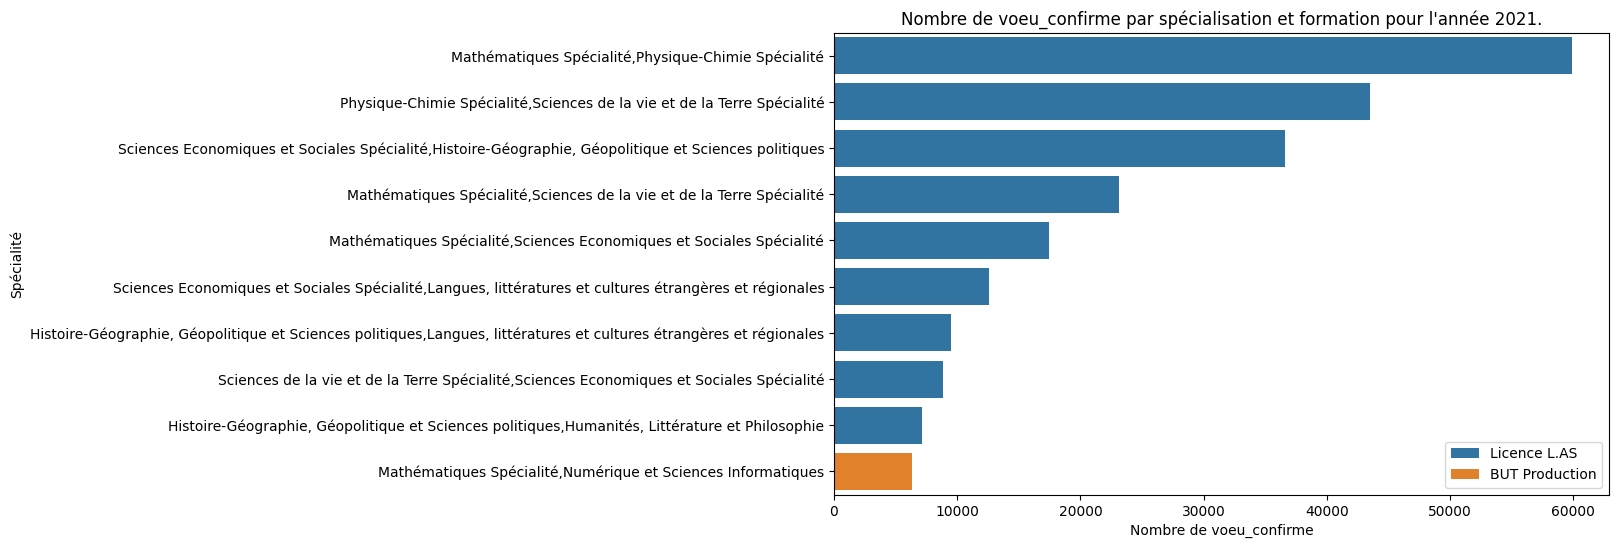

In [15]:
get_graph_by_year_column_from_spe(2021, "voeu_confirme")

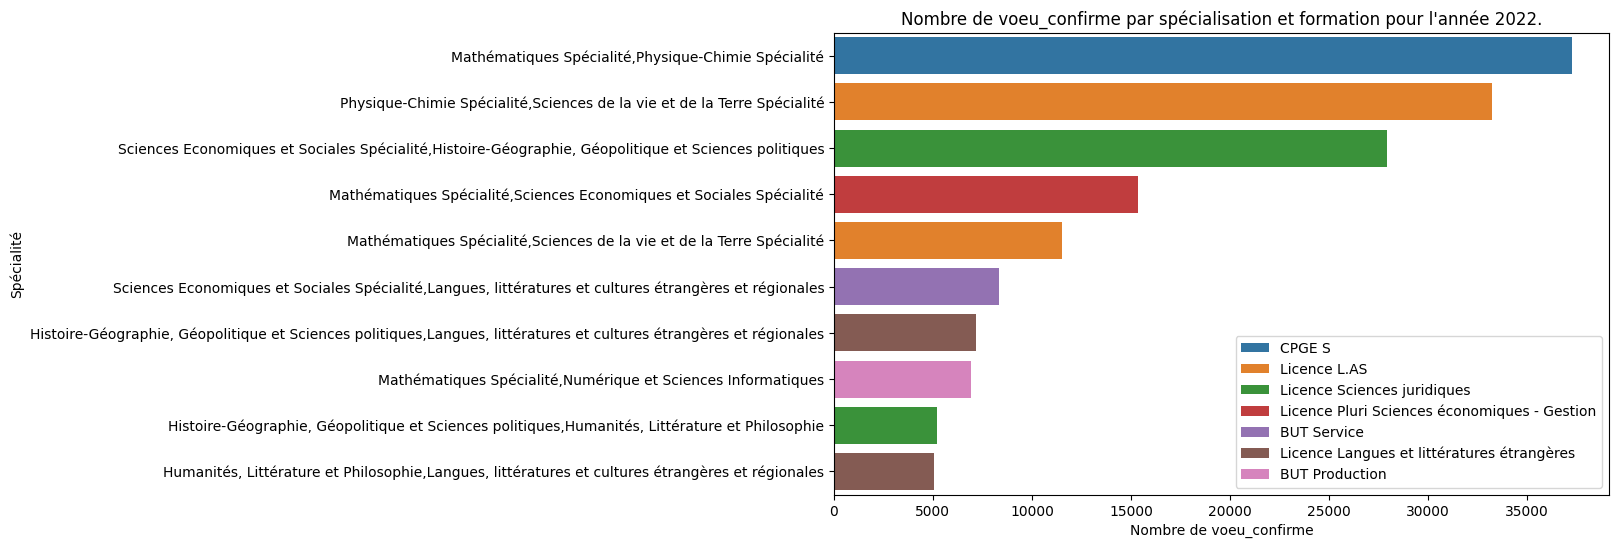

In [16]:
get_graph_by_year_column_from_spe(2022, "voeu_confirme")

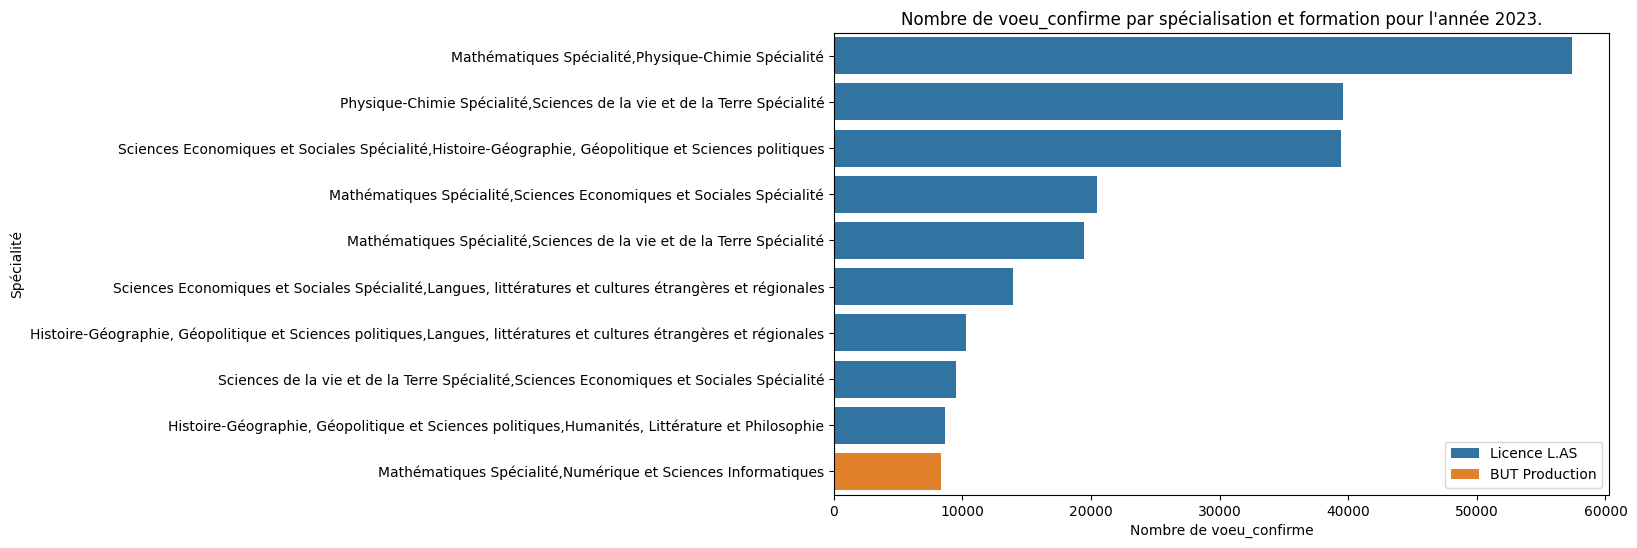

In [17]:
get_graph_by_year_column_from_spe(2023, "voeu_confirme")

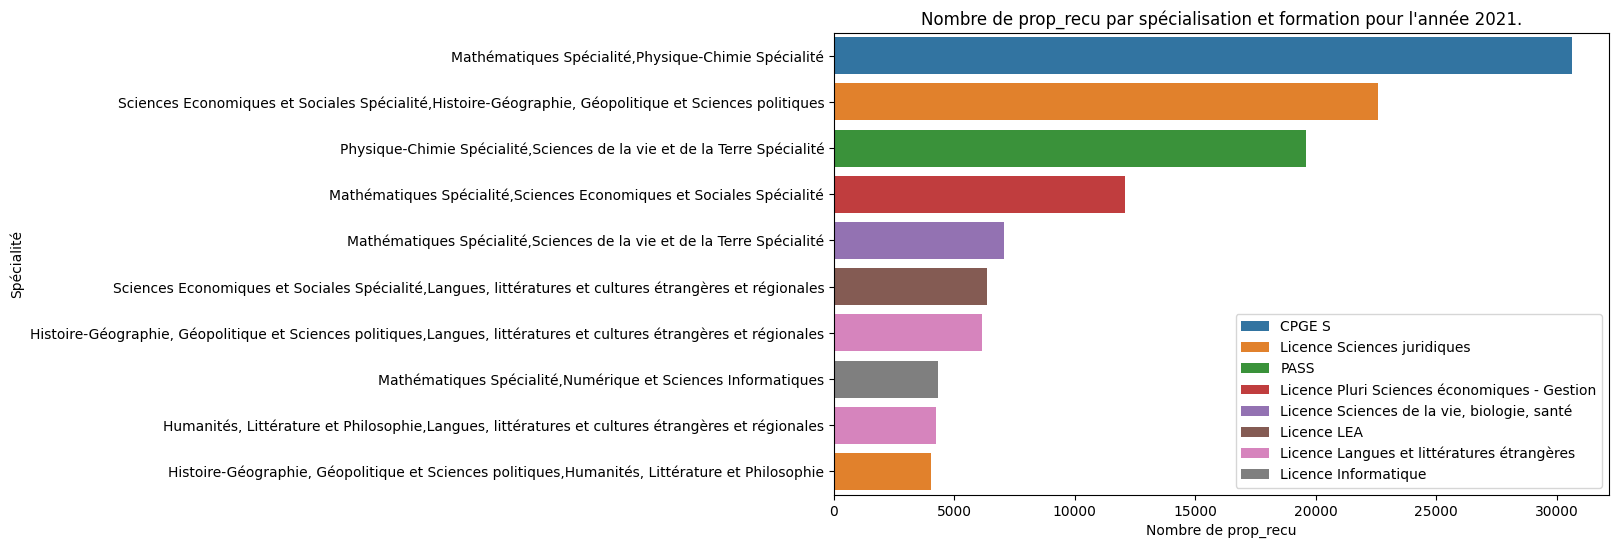

In [18]:
get_graph_by_year_column_from_spe(2021, "prop_recu")

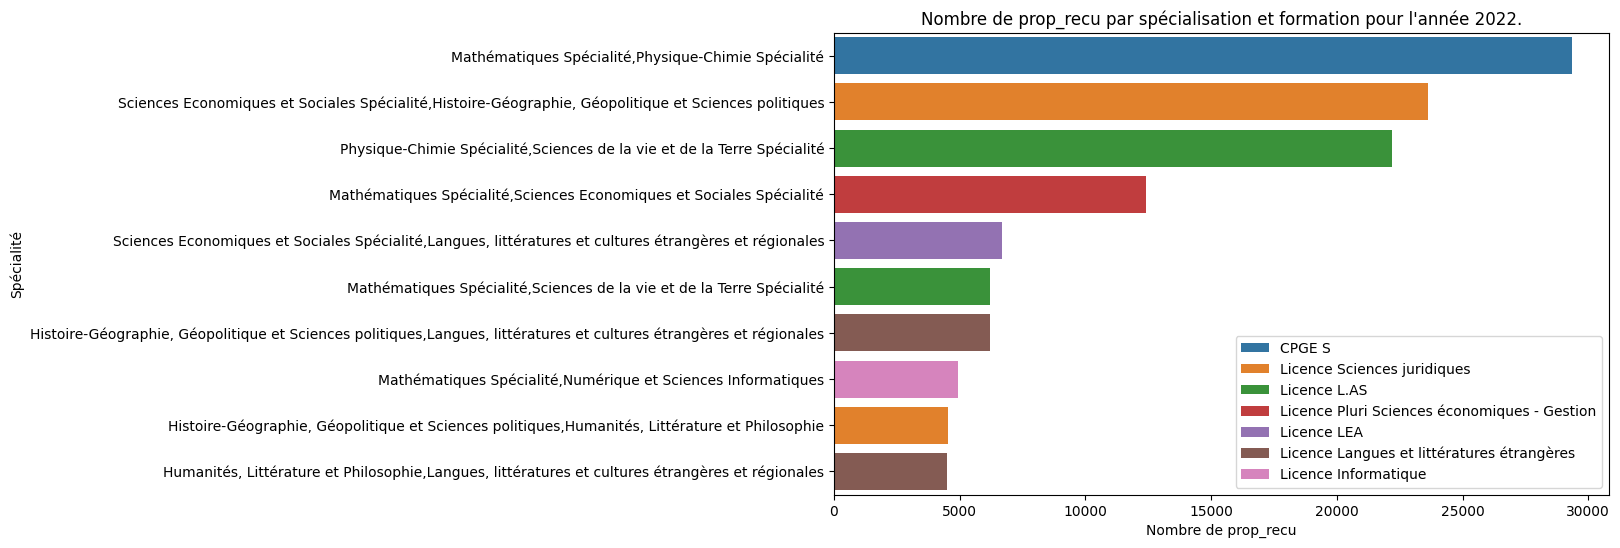

In [19]:
get_graph_by_year_column_from_spe(2022, "prop_recu")

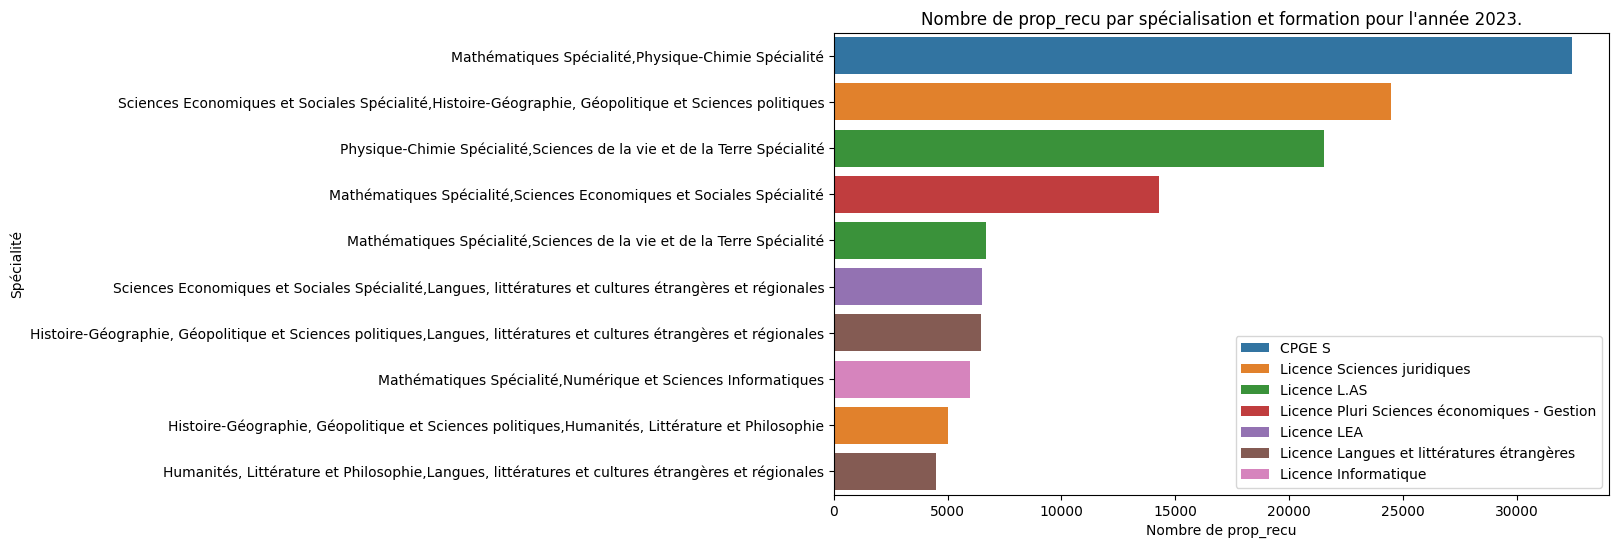

In [20]:
get_graph_by_year_column_from_spe(2023, "prop_recu")

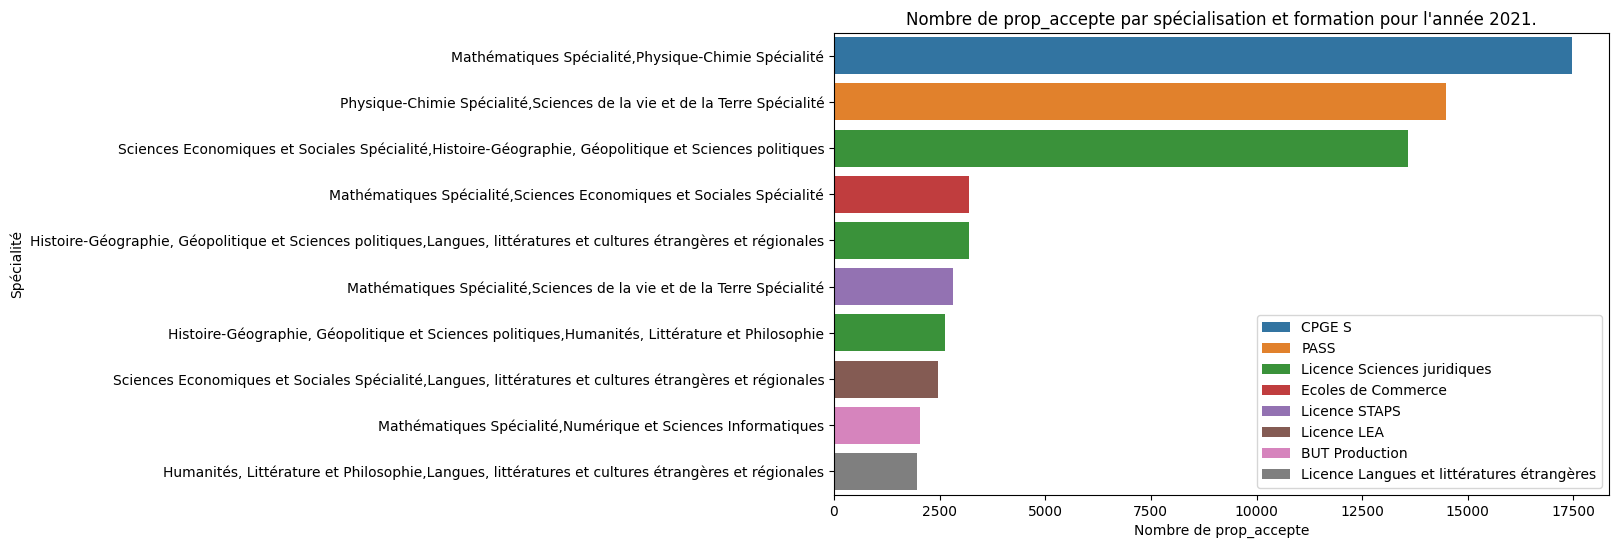

In [21]:
get_graph_by_year_column_from_spe(2021, "prop_accepte")

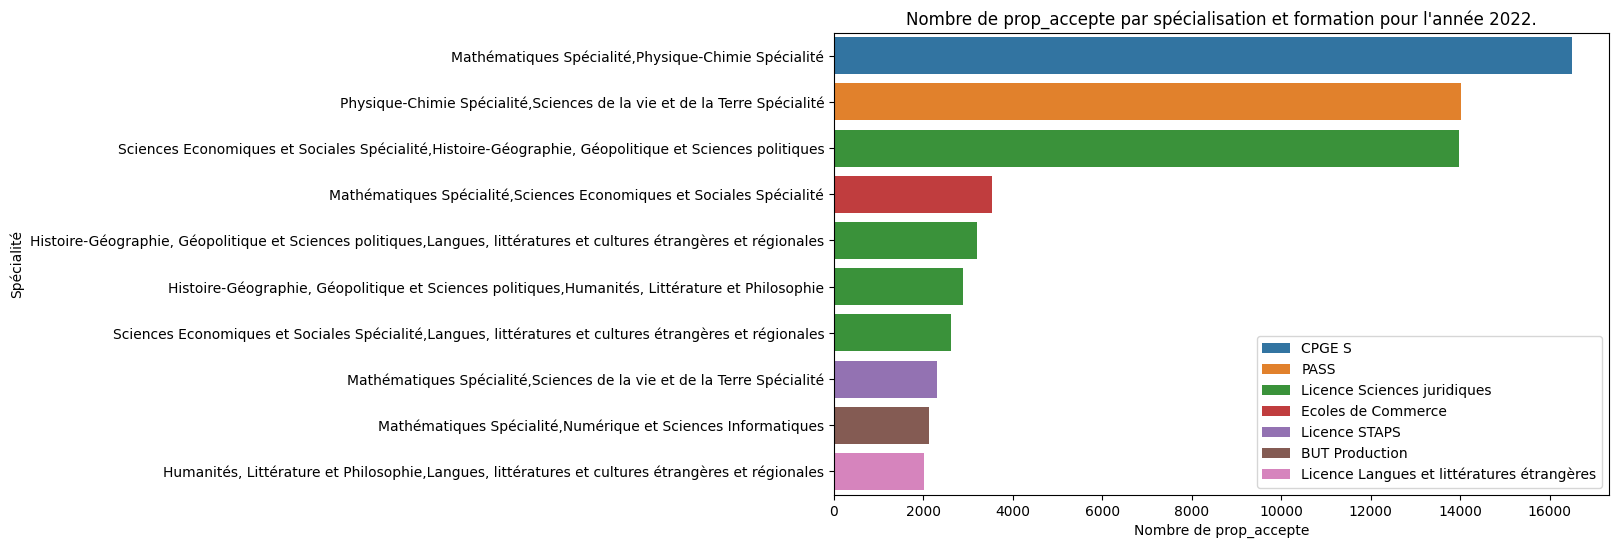

In [22]:
get_graph_by_year_column_from_spe(2022, "prop_accepte")

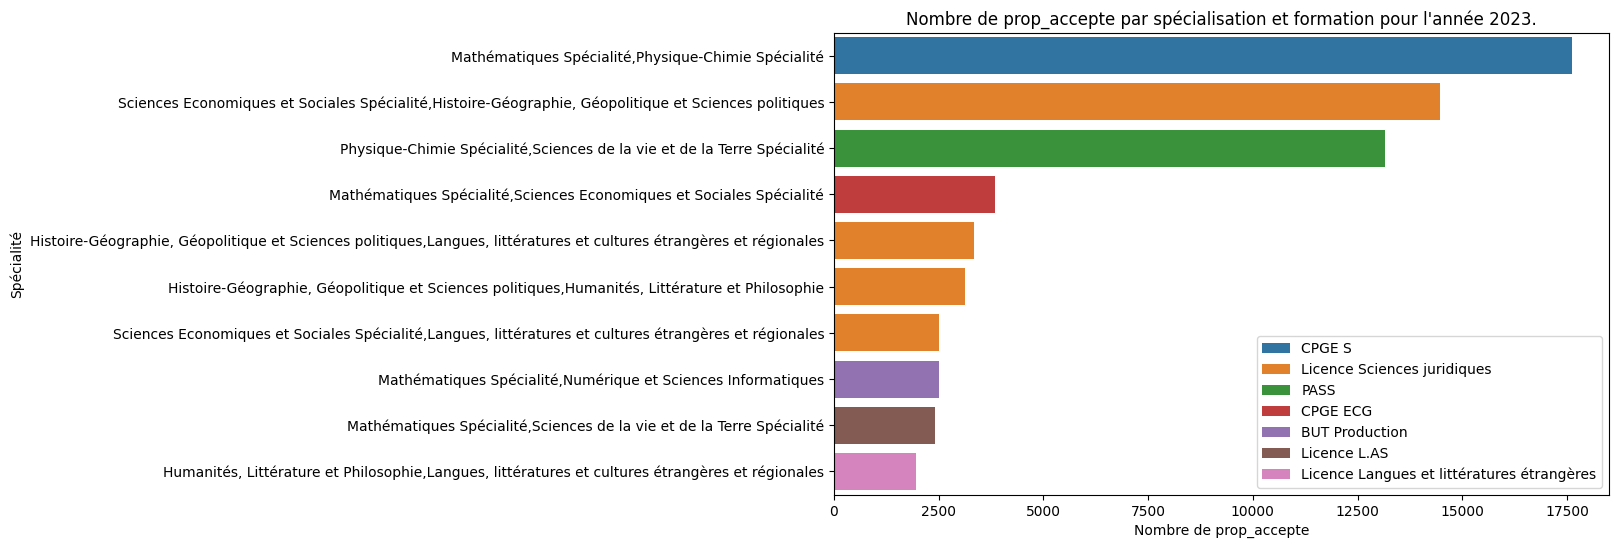

In [23]:
get_graph_by_year_column_from_spe(2023, "prop_accepte")

In [24]:
def create_graph_from_formation(df,colonne, annee) :
    df_graph = df.head(10)
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df_graph, x=colonne, y='formation', hue='spe')
    plt.title(f'Nombre de {colonne} par formation et spécialisation pour l\'année {annee}.')
    plt.xlabel(f'Nombre de {colonne}')
    plt.ylabel('Formation')
    plt.legend()
    plt.show()

In [25]:
def get_graph_by_year_column_from_formation(annee, colonne):
    df_tmp = pd.DataFrame()
    for i in df["formation"].unique():
        mask = ((df["annee"] == annee) & (df["formation"] == i))
        max = df[mask][colonne].max()
        new_mask = ((df["annee"] == annee) & (df["formation"] == i) & (df[colonne] == max))

        df_tmp = pd.concat([df_tmp,df[new_mask]],ignore_index=True)
        df_tmp = df_tmp.sort_values(by=colonne,ascending=False)
    create_graph_from_formation(df_tmp,colonne, annee)
    

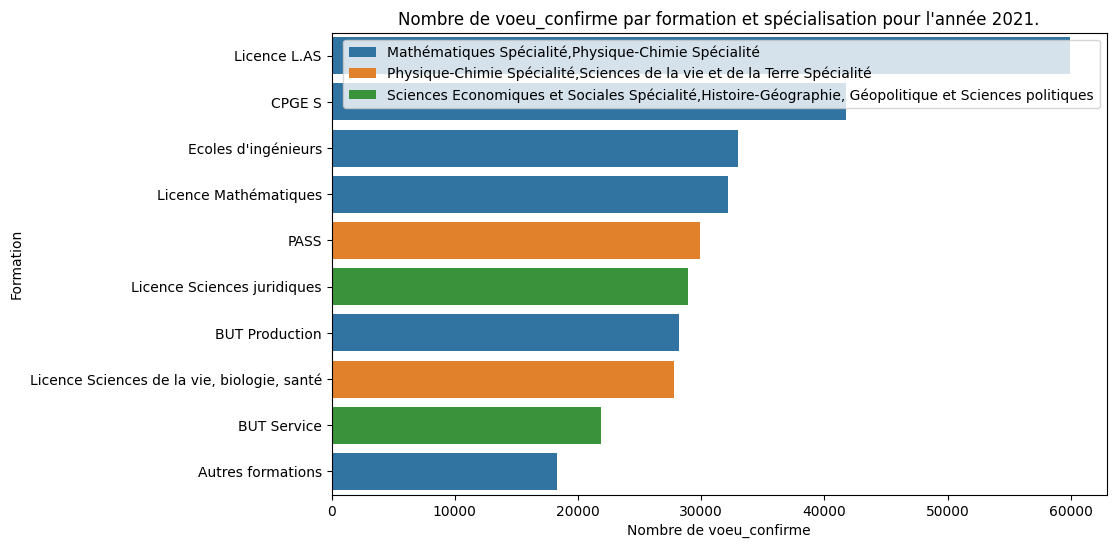

In [26]:
get_graph_by_year_column_from_formation(2021, "voeu_confirme")

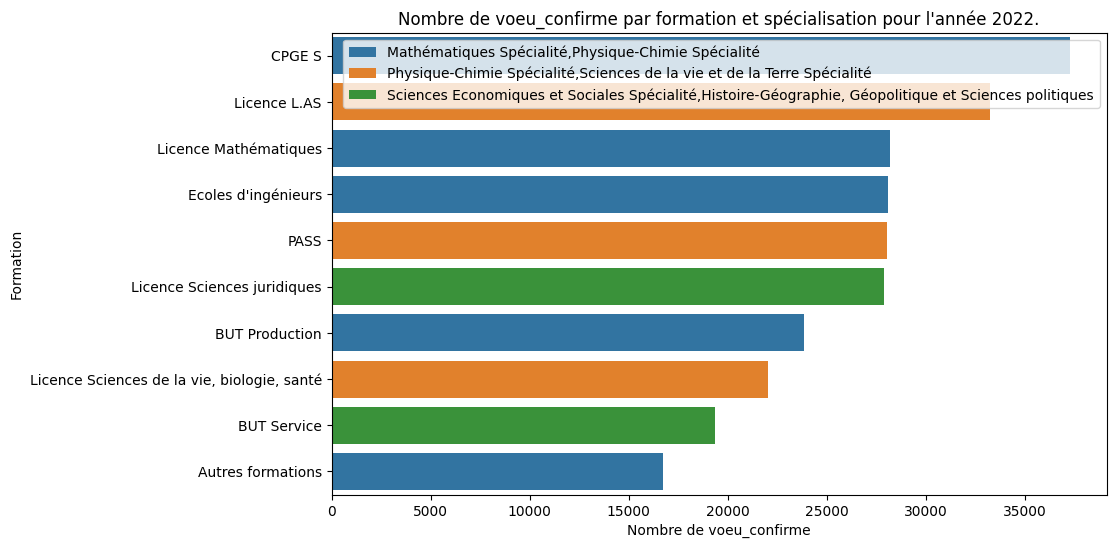

In [27]:
get_graph_by_year_column_from_formation(2022, "voeu_confirme")

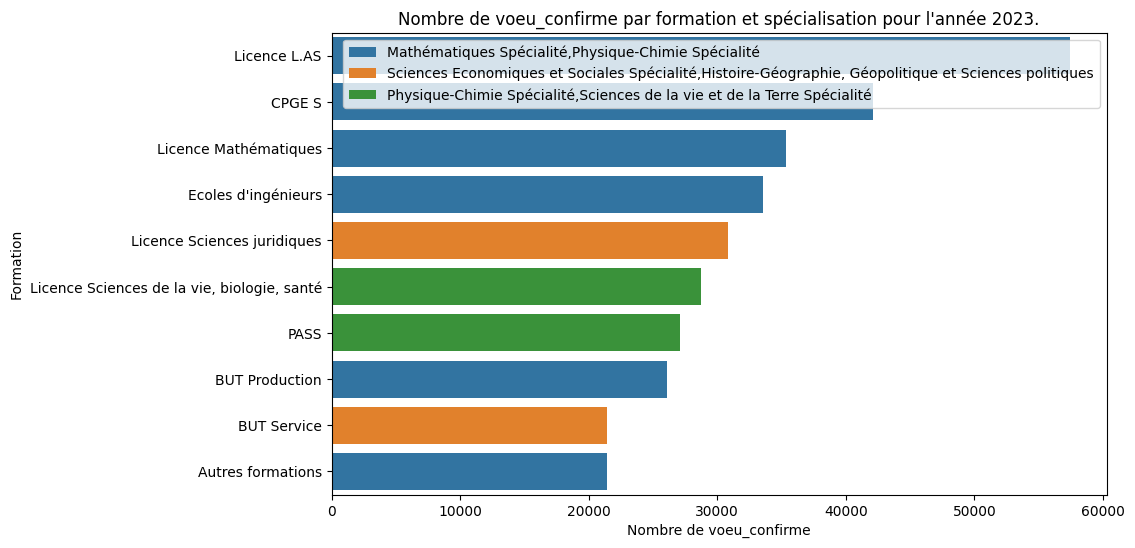

In [28]:
get_graph_by_year_column_from_formation(2023, "voeu_confirme")

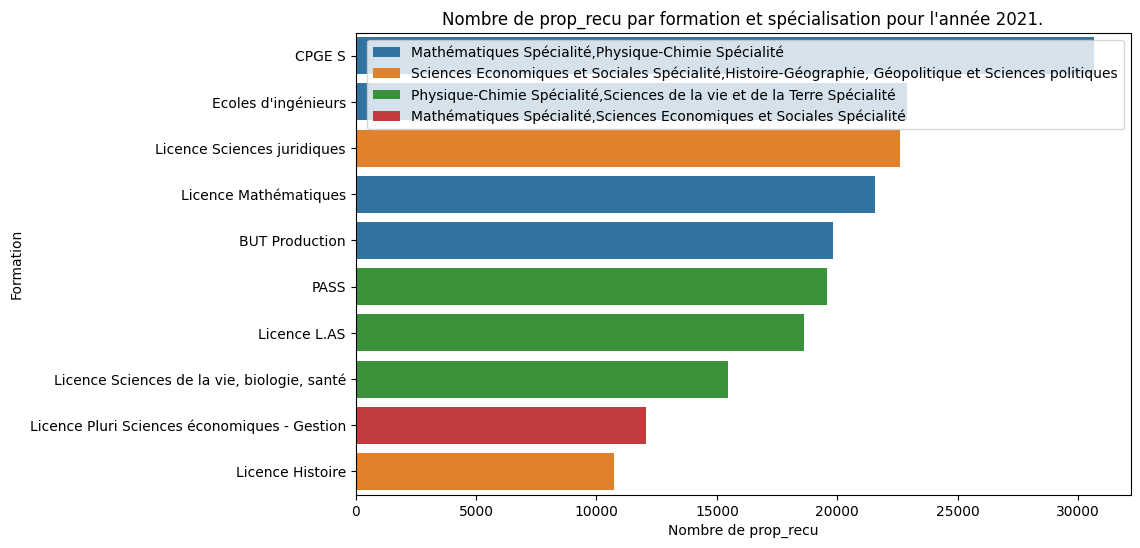

In [29]:
get_graph_by_year_column_from_formation(2021, "prop_recu")

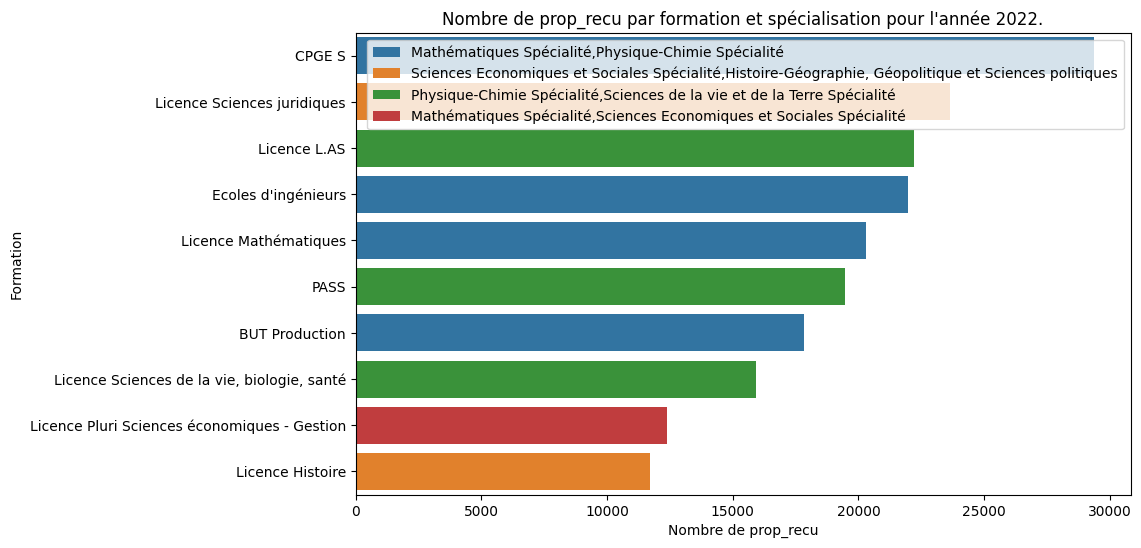

In [30]:
get_graph_by_year_column_from_formation(2022, "prop_recu")

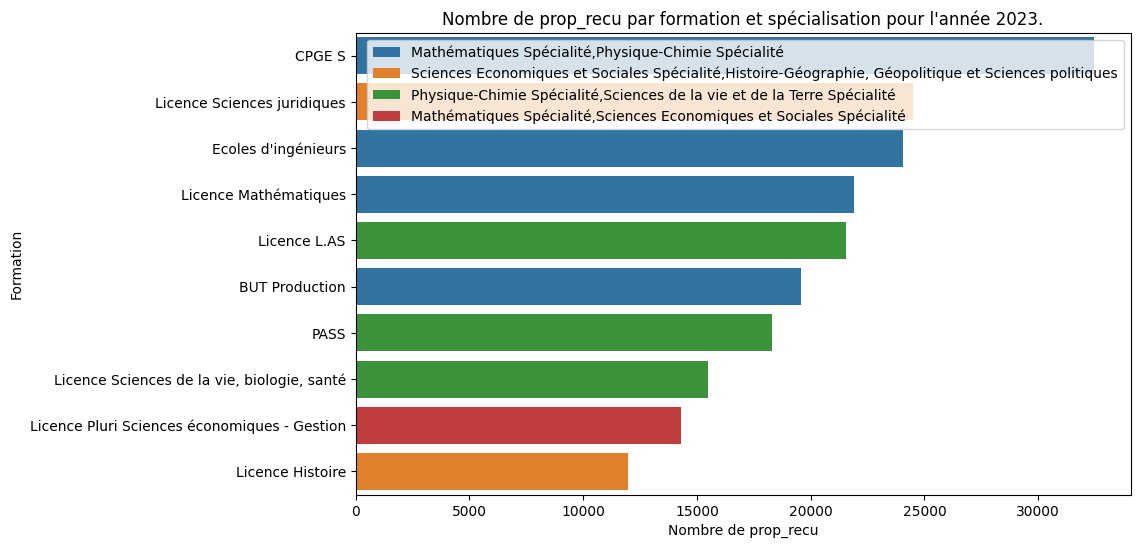

In [31]:
get_graph_by_year_column_from_formation(2023, "prop_recu")

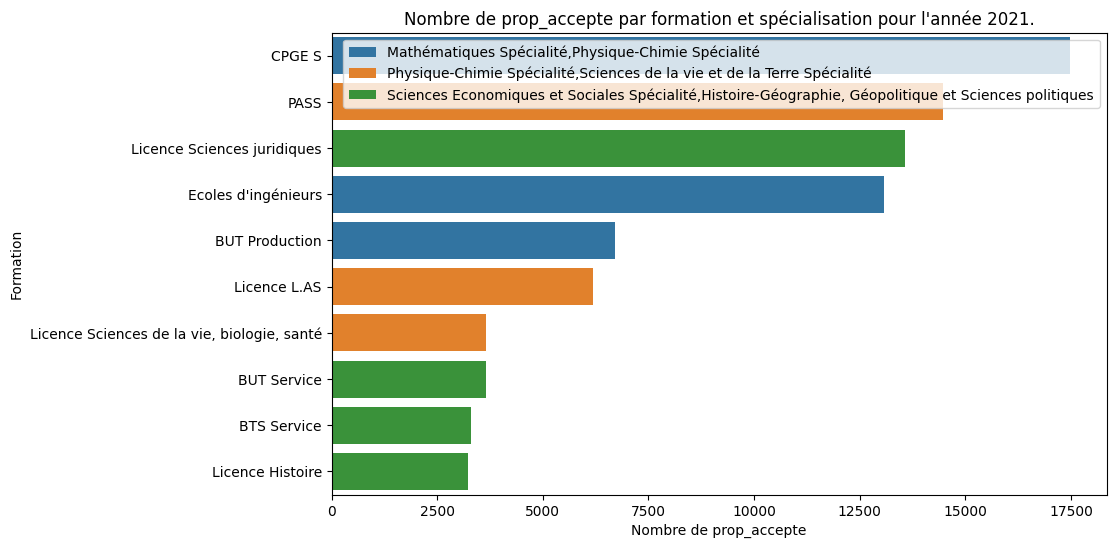

In [32]:
get_graph_by_year_column_from_formation(2021, "prop_accepte")

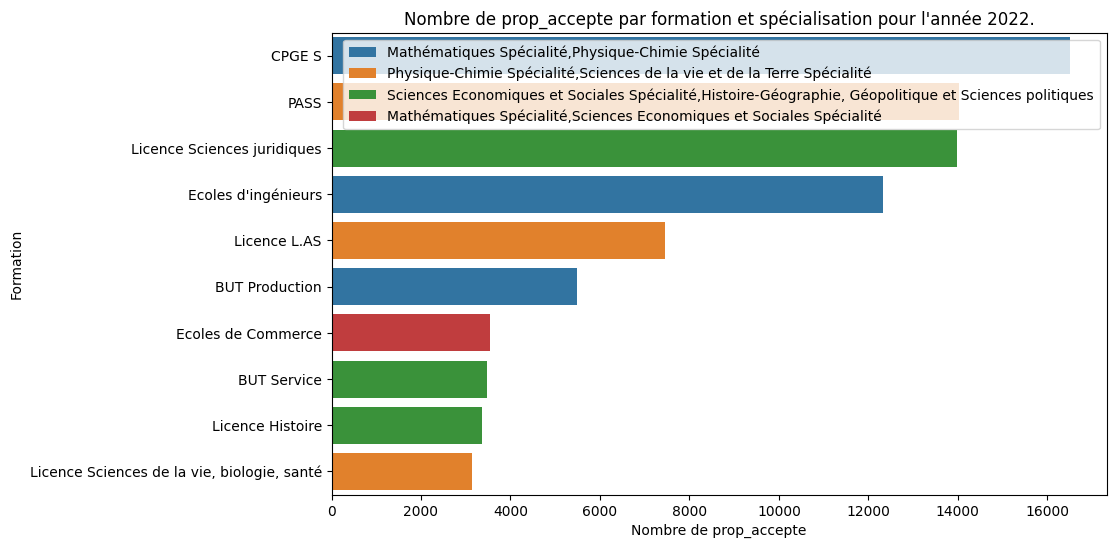

In [33]:
get_graph_by_year_column_from_formation(2022, "prop_accepte")

### Conclusion de l'analyse

Nous pouvons voir que pour les trois années analysée dans tous les cas on retrouve de manière globale les mêmes formations et même duo de spécialités. A savoir CPGE S pour la formation et Mathématique Physique et Chimie pour les duo de spé. 

## Approche sur la problématique

Pour poursuivre l'analyse de nos données nous regardons maintenant les proportions globales des différents bachelier et de leurs formations. L'idée est de pouvoir prédire le nombre de nouveaux arrivants en première année d'études supérieurs pour chaque formations recensées. 

Pour se faire on regarde pour chaque année la proportions de chaque duo de formations étant acceptée dans une formation d'études supérieurs. Cette approche nous place du point de vue de l'établissement de formation supérieur cherchant à anticiper ses besoins par rapport aux prochains effectifs. De ce fait on pourra voir rapidement, en fonction du nombre de bacheliers, le nombre de nouveaux étudiants qu'il faut s'attendre à accueillir.

On pourra aussi regarder dans un second temps une approche qui nous placerait du point du Lycée chercher à orienter ses futurs bacheliers. Pour se faire il faudrait regarder pour chaque duo, quel est le pourcentage d'étudiants qui réussissent à être accepter dans quelles formations. De ce fait prenont un lycéen qui aimerait faire une école d'ingénieur et alors il pourra rapidement voir quel duo de scpécialité est le plus susceptible de lui ouvrir les voies qu'il souhaite.

In [71]:
df_bachelier = pd.DataFrame(columns=['nb_bachelier', 'proportion_bachelier', 'annee','formation'])
for i in df["annee"].unique() :
    nb_bachelier_total = df[df["annee"] == i]["prop_accepte"].sum()
    for j in df["formation"].unique():
        mask = ((df['formation'] == j) & (df["annee"] == i))
        nb_bachelier = df[mask]["prop_accepte"].sum()
        proportion_bachelier=(nb_bachelier/nb_bachelier_total)*100
        nouvelle_ligne = {'nb_bachelier': nb_bachelier, 'proportion_bachelier': proportion_bachelier, 'annee': i,"formation" : j}
        df_bachelier = pd.concat([df_bachelier, pd.DataFrame([nouvelle_ligne])], ignore_index=True)


df_bachelier = df_bachelier.sort_values(by=["annee","proportion_bachelier"],ascending=[True,False])
#print(df_tmp["proportion_bachelier_formation"].sum())
#print("L'année est : ",i,", la formation est : ",j,", le nombre de bachelier ayant validé cette option est de : ",nb_bachelier_formation,", la proportion est de :",proportion_bachelier_formation,"%")
for index, row in df_bachelier.iterrows():
    print("-" * 40)
    print(f'Nous sommes en {row["annee"]}, la formation étudiée est {row["formation"]},\nil y a {row["nb_bachelier"]} bacheliers ayant validé ce voeu, ce qui correspond à {row["proportion_bachelier"]}%.')

/tmp/ipykernel_2074/1770648028.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_bachelier = pd.concat([df_bachelier, pd.DataFrame([nouvelle_ligne])], ignore_index=True)


----------------------------------------
Nous sommes en 2021, la formation étudiée est Licence Sciences juridiques,
il y a 33114 bacheliers ayant validé ce voeu, ce qui correspond à 9.947489846434838%.
----------------------------------------
Nous sommes en 2021, la formation étudiée est PASS,
il y a 24615 bacheliers ayant validé ce voeu, ce qui correspond à 7.394378890197303%.
----------------------------------------
Nous sommes en 2021, la formation étudiée est CPGE S,
il y a 21408 bacheliers ayant validé ce voeu, ce qui correspond à 6.430991805051549%.
----------------------------------------
Nous sommes en 2021, la formation étudiée est Ecoles d'ingénieurs,
il y a 17593 bacheliers ayant validé ce voeu, ce qui correspond à 5.284960707505227%.
----------------------------------------
Nous sommes en 2021, la formation étudiée est BUT Production,
il y a 15184 bacheliers ayant validé ce voeu, ce qui correspond à 4.561293888635216%.
----------------------------------------
Nous sommes en

In [80]:
df_bachelier[df_bachelier["formation"] == "DEUST"]


,nb_bachelier,proportion_bachelier,annee,formation
42,483,0.145094,2021,DEUST
106,493,0.153804,2022,DEUST
170,1098,0.329761,2023,DEUST


Maintenant nous calculons les moyennes pour chaque formation du nombre de bacheliers, ainsi que la moyenne des proportions 

In [73]:
df_bachelier_mean = df_bachelier[["formation","nb_bachelier","proportion_bachelier"]].groupby(by="formation").mean()
df_bachelier_mean["nb_bachelier"] = df_bachelier_mean["nb_bachelier"].round(0).astype(int)
df_bachelier_mean["proportion_bachelier"] = df_bachelier_mean["proportion_bachelier"].round(3)

In [74]:
df_bachelier_mean = df_bachelier_mean.sort_values(by="nb_bachelier", ascending=False)

Grâce au code ci-dessus nous pouvons désormais prédire, pour les futurs année, en connaissant le nombre de bachelier de l'année, le nombre de bacheliers qui iront dans chacune des formations.

Maintenant nous calculons l'écart type afin de vérifier si les données que nous avons sur les différentes années ont beaucoup de différence d'une année à l'autre, ou non. Selon ces écarts types, nous pourrons calculer une marge d'erreur qui signifiera que les données d'une formation au delà d'un certain seuil d'erreur n'auront pas de valeur car elles sont trop changeante d'une année à l'autre

In [75]:
df_bachelier_mean["ecart_type_nb"] = df_bachelier.groupby(by="formation")["nb_bachelier"].std().round(3)
df_bachelier_mean["ecart_type_proportion"] = df_bachelier.groupby(by="formation")["proportion_bachelier"].std().round(3)
df_bachelier_mean.head(10)

,nb_bachelier,proportion_bachelier,ecart_type_nb,ecart_type_proportion
formation,,,,
Licence Sciences juridiques,32678,9.941,404.023,0.145
PASS,23262,7.074,1173.398,0.299
CPGE S,21301,6.479,480.955,0.046
Ecoles d'ingénieurs,17804,5.416,264.694,0.123
Licence L.AS,14547,4.427,1349.401,0.442
BUT Production,14414,4.382,758.747,0.158
Licence STAPS,13429,4.086,593.626,0.221
BTS Service,13358,4.056,1758.442,0.452
Ecoles de Commerce,11991,3.650,331.180,0.181


Pour calculer la marge d'erreur, nous utilisons l'écart type divisé par le nombre moyen de bachelier, cela permet de rester juste pour chacune des formations.

In [76]:
df_bachelier_mean["marge_erreur_nb"]=((df_bachelier_mean["ecart_type_nb"]/df_bachelier_mean["nb_bachelier"])*100).round(3)
df_bachelier_mean["marge_erreur_proportion"]=((df_bachelier_mean["ecart_type_proportion"]/df_bachelier_mean["proportion_bachelier"])*100).round(3)

In [77]:
df_bachelier_mean.head(60)

,nb_bachelier,proportion_bachelier,ecart_type_nb,ecart_type_proportion,marge_erreur_nb,marge_erreur_proportion
formation,,,,,,
Licence Sciences juridiques,32678,9.941,404.023,0.145,1.236,1.459
PASS,23262,7.074,1173.398,0.299,5.044,4.227
CPGE S,21301,6.479,480.955,0.046,2.258,0.710
Ecoles d'ingénieurs,17804,5.416,264.694,0.123,1.487,2.271
Licence L.AS,14547,4.427,1349.401,0.442,9.276,9.984
BUT Production,14414,4.382,758.747,0.158,5.264,3.606
Licence STAPS,13429,4.086,593.626,0.221,4.420,5.409
BTS Service,13358,4.056,1758.442,0.452,13.164,11.144
Ecoles de Commerce,11991,3.650,331.180,0.181,2.762,4.959


Il est désormais possible de traiter ces résultats et de définir un seuil au dessus duquel nous considérerons que les valeurs des données ne sont pas assez proches pour être utilisables et que les données sont trop changeante d'une année à l'autre pour prédire des données de cette formation.

In [84]:
df_bachelier_mean = df_bachelier_mean[df_bachelier_mean["marge_erreur_proportion"] <10]
df_bachelier_mean.head(50)

,nb_bachelier,proportion_bachelier,ecart_type_nb,ecart_type_proportion,marge_erreur_nb,marge_erreur_proportion
formation,,,,,,
Licence Sciences juridiques,32678,9.941,404.023,0.145,1.236,1.459
PASS,23262,7.074,1173.398,0.299,5.044,4.227
CPGE S,21301,6.479,480.955,0.046,2.258,0.710
Ecoles d'ingénieurs,17804,5.416,264.694,0.123,1.487,2.271
Licence L.AS,14547,4.427,1349.401,0.442,9.276,9.984
BUT Production,14414,4.382,758.747,0.158,5.264,3.606
Licence STAPS,13429,4.086,593.626,0.221,4.420,5.409
Ecoles de Commerce,11991,3.650,331.180,0.181,2.762,4.959
BUT Service,11906,3.620,589.055,0.119,4.948,3.287
